# PV Notebook
This notebook will explore solar generation around the ERCOT 4CP events.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import sqlalchemy as sqla
import os
from config.read_config import get_database_config
import sys
sys.executable  # shows you your path to the python you're using

'/Users/esha/anaconda3/bin/python'

In [86]:
%matplotlib inline

In [87]:
# read in db credentials from config/config.txt
# * make sure you add those to the config/config.txt file! *

database_config = get_database_config("./config/config.txt")


In [88]:
# get our DB connection
engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))


In [89]:
# These are the ERCOT 4CP events for 2016 - 2019 acquired from
# http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13037&reportTitle=Planned%20Service%20Four%20Coincident%20Peak%20Calculations&showHTMLView=&mimicKey

event_start_dates = ['2019-06-19 17:00:00-05', '2019-07-30 16:30:00-05', '2019-08-12 17:00:00-05', '2019-09-06 16:45:00-05',
               '2018-06-27 17:00:00-05', '2018-07-19 17:00:00-05', '2018-08-23 16:45:00-05', '2018-09-19 16:30:00-05',
               '2017-06-23 16:45:00-05', '2017-07-28 17:00:00-05', '2017-08-16 17:00:00-05', '2017-09-20 16:45:00-05',
               '2016-06-15 17:00:00-05', '2016-07-14 16:00:00-05', '2016-08-11 16:30:00-05', '2016-09-19 16:16:00-05'
              ]
event_end_dates = ['2019-06-19 17:15:00-05', '2019-07-30 16:45:00-05', '2019-08-12 17:15:00-05', '2019-09-06 17:00:00-05',
               '2018-06-27 17:15:00-05', '2018-07-19 17:15:00-05', '2018-08-23 17:00:00-05', '2018-09-19 16:45:00-05',
               '2017-06-23 17:00:00-05', '2017-07-28 17:15:00-05', '2017-08-16 17:15:00-05', '2017-09-20 17:00:00-05',
               '2016-06-15 17:15:00-05', '2016-07-14 16:15:00-05', '2016-08-11 16:45:00-05', '2016-09-19 16:31:00-05']

In [90]:
# Select the dataids, pv direction, amount of PV of solar homes
# we're selecting homes with just South and West facing PV that have data between the first event and the last event


query = """
select dataid, pv, pv_panel_direction, total_amount_of_pv, amount_of_west_facing_pv, amount_of_south_facing_pv
from other_datasets.metadata
where pv is not null
and total_amount_of_pv is not null
and grid is not null 
and solar is not null
and pv_panel_direction in ('South', 'West')
and egauge_1min_min_time < '2016-06-15'
and egauge_1min_max_time > '2019-09-06'
"""

# create a dataframe with the data from the sql query
df = pd.read_sql_query(sqla.text(query), engine)
df

,dataid,pv,pv_panel_direction,total_amount_of_pv,amount_of_west_facing_pv,amount_of_south_facing_pv
0,8086,yes,West,5.635,5.635,NaN
1,7030,yes,South,5.250,0.000,5.250
2,8467,yes,South,5.180,0.000,5.180
3,8419,yes,South,4.070,0.000,4.070
4,7800,yes,South,5.145,0.000,5.145
5,7741,yes,South,6.125,0.000,6.125
6,7739,yes,South,5.000,0.000,5.000
7,5796,yes,South,4.250,0.000,4.250
8,5738,yes,West,5.920,5.920,NaN
9,5129,yes,South,5.145,0.000,5.145


In [91]:
# grab dataids and convert them to a string to put into the SQL query
dataids_list = df['dataid'].tolist()
dataids_list
print("{} dataids selected listed here:".format(len(dataids_list)))
dataids_str = ','.join(list(map(str, dataids_list)))
dataids_str
dataids_list

46 dataids selected listed here:


[8086,
 7030,
 8467,
 8419,
 7800,
 7741,
 7739,
 5796,
 5738,
 5129,
 2470,
 7767,
 1169,
 187,
 9932,
 890,
 4357,
 6643,
 6139,
 93,
 5439,
 171,
 5892,
 8626,
 2199,
 9134,
 8767,
 8317,
 8084,
 7940,
 6836,
 5972,
 4336,
 3482,
 3039,
 3009,
 2814,
 2461,
 2233,
 744,
 661,
 5357,
 3506,
 3649,
 6691,
 7719]

In [92]:
# Assemble the SQL query to pull the data for the selected dataids
# 
first_start = event_start_dates.pop(0)
first_end   = event_end_dates.pop(0)
query_2 = """
select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '{}' and localminute <= '{}') """.format(first_start, first_end)

for start, end in zip(event_start_dates, event_end_dates):
    query_2 = query_2 + "OR (localminute >= '{}' and localminute <= '{}') ".format(start, end)

query_2 = query_2 + """ ) AND dataid in ({})""".format(dataids_str)

# here's what that query is
print("sql query is \n" + query_2)

# create a dataframe with the data from the sql query
df2 = pd.read_sql_query(sqla.text(query_2), engine)

# calculate usage as grid minus solar (which is actually grid + solar because solar is negative use)
# Calculate the difference with a lambda function and add it as a new column called 'usage'
df2['usage'] = df2.apply(lambda row: row.solar + row.grid, axis=1)
df2.head(15)

sql query is 

select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '2019-06-19 17:00:00-05' and localminute <= '2019-06-19 17:15:00-05') OR (localminute >= '2019-07-30 16:30:00-05' and localminute <= '2019-07-30 16:45:00-05') OR (localminute >= '2019-08-12 17:00:00-05' and localminute <= '2019-08-12 17:15:00-05') OR (localminute >= '2019-09-06 16:45:00-05' and localminute <= '2019-09-06 17:00:00-05') OR (localminute >= '2018-06-27 17:00:00-05' and localminute <= '2018-06-27 17:15:00-05') OR (localminute >= '2018-07-19 17:00:00-05' and localminute <= '2018-07-19 17:15:00-05') OR (localminute >= '2018-08-23 16:45:00-05' and localminute <= '2018-08-23 17:00:00-05') OR (localminute >= '2018-09-19 16:30:00-05' and localminute <= '2018-09-19 16:45:00-05') OR (localminute >= '2017-06-23 16:45:00-05' and localminute <= '2017-06-23 17:00:00-05') OR (localminute >= '2017-07-28 17:00:00-05' and localminute <= '2017-07-28 17:15:00-05') OR (localminute

,dataid,localminute,solar,grid,usage
0,3506,2017-06-23 21:45:00+00:00,2.253,1.739,3.992
1,3506,2017-06-23 21:46:00+00:00,2.238,1.733,3.971
2,3506,2017-06-23 21:47:00+00:00,2.207,1.776,3.983
3,3506,2017-06-23 21:48:00+00:00,2.204,1.886,4.090
4,3506,2017-06-23 21:49:00+00:00,2.192,1.897,4.089
5,3506,2017-06-23 21:50:00+00:00,2.171,1.909,4.080
6,3506,2017-06-23 21:51:00+00:00,2.131,1.903,4.034
7,3506,2017-06-23 21:52:00+00:00,2.117,1.868,3.985
8,3506,2017-06-23 21:53:00+00:00,2.104,1.895,3.999
9,3506,2017-06-23 21:54:00+00:00,2.088,1.913,4.001


In [93]:
#Total number of records in the dataset
df2['dataid'].count()

11296

In [106]:
#Checking completeness of data. We will consider only those homes that have 100% data for the CP dates
data = df2.groupby(['dataid']).size().reset_index(name='counts')
data['perc'] = (data['counts']/256)*100
ndata = data[data['perc'] == 100]
final_dataids = ndata['dataid']

df3=df2.loc[df2['dataid'].isin(final_dataids)]
df3.count()


dataid         8704
localminute    8704
solar          8704
grid           8704
usage          8704
dtype: int64

In [107]:
df3 = df3.dropna()

In [108]:
# convert localminute to pandas datetime type
df3['datetime'] = pd.to_datetime(df3['localminute'])

# and set as index
df3 = df3.set_index('datetime')
df3

,dataid,localminute,solar,grid,usage
datetime,,,,,
2017-06-23 21:45:00+00:00,3506,2017-06-23 21:45:00+00:00,2.253,1.739,3.992
2017-06-23 21:46:00+00:00,3506,2017-06-23 21:46:00+00:00,2.238,1.733,3.971
2017-06-23 21:47:00+00:00,3506,2017-06-23 21:47:00+00:00,2.207,1.776,3.983
2017-06-23 21:48:00+00:00,3506,2017-06-23 21:48:00+00:00,2.204,1.886,4.090
2017-06-23 21:49:00+00:00,3506,2017-06-23 21:49:00+00:00,2.192,1.897,4.089
2017-06-23 21:50:00+00:00,3506,2017-06-23 21:50:00+00:00,2.171,1.909,4.080
2017-06-23 21:51:00+00:00,3506,2017-06-23 21:51:00+00:00,2.131,1.903,4.034
2017-06-23 21:52:00+00:00,3506,2017-06-23 21:52:00+00:00,2.117,1.868,3.985
2017-06-23 21:53:00+00:00,3506,2017-06-23 21:53:00+00:00,2.104,1.895,3.999


In [109]:
# group by month and dataid and take the mean of solar, grid, and usage within those groups
grouped = df3.groupby([pd.Grouper(freq='M'), 'dataid']).mean()
grouped

solar      grid     usage
datetime                  dataid                              
2016-06-30 00:00:00+00:00 171     3.855063 -1.513812  2.341250
                          187     3.410312  1.176313  4.586625
                          661     2.378437  0.980875  3.359312
                          744     1.639937  2.335188  3.975125
                          1169    1.522562 -0.330250  1.192312
                          2199    1.674187 -1.338688  0.335500
                          2233    1.628187  6.170750  7.798938
                          2814    3.983125  1.275875  5.259000
                          3009    2.352750  0.133438  2.486188
                          3039    3.745500  1.136625  4.882125
                          3482    3.189125 -1.373188  1.815937
                          3506    2.080938 -0.609000  1.471937
                          3649    2.350188  5.059500  7.409687
                          5129    1.819687  0.698438  2.518125
                          5357    6.510437 -0.499813  6.010625
                          5439    1.461500  0.336375  1.797875
                          5738    3.684187  1.273500  4.957688
                          5796    1.542312  0.707250  2.249562
                          5892    3.073687  1.995625  5.069312
                          6139    1.854312  2.635688  4.490000
                          6691    2.599563  0.274937  2.874500
                          7030    1.878563 -0.122500  1.756062
                          7719    2.522812  4.195250  6.718063
                          7739    1.696750 -0.908375  0.788375
                          7741    2.202125  0.436625  2.638750
                          8084    2.882125 -2.303875  0.578250
                          8086    3.523312 -1.181687  2.341625
                          8317    1.080125  0.104750  1.184875
                          8419    1.465812  1.543938  3.009750
                          8467    1.765000  0.886437  2.651438
...                                    ...       ...       ...
2019-09-30 00:00:00+00:00 1169    1.476625 -1.080312  0.396313
                          2199    0.950125 -0.773625  0.176500
                          2233    0.931875  3.742125  4.674000
                          2814    3.415437 -2.840063  0.575375
                          3009    1.644625  1.409375  3.054000
                          3039    3.084375 -2.093125  0.991250
                          3482    2.537500 -1.108313  1.429187
                          3506    2.010063  1.567438  3.577500
                          3649    2.123937 -1.016125  1.107812
                          5129    1.911187 -0.339500  1.571687
                          5357    3.353500  5.151313  8.504812
                          5439    1.512125  1.006125  2.518250
                          5738    3.191187  2.050625  5.241812
                          5796    1.581062  2.036000  3.617062
                          5892    2.759500  2.403062  5.162562
                          6139    1.362812 -0.402938  0.959875
                          6691    1.315250  3.806625  5.121875
                          7030    2.112125  2.022813  4.134938
                          7719    2.528437  3.268813  5.797250
                          7739    1.119937  0.532625  1.652563
                          7741    2.076250 -1.925937  0.150313
                          8084    3.314875  2.245687  5.560562
                          8086    3.107625 -0.754312  2.353313
                          8317    0.839000  1.699938  2.538938
                          8419    1.388125  3.811313  5.199438
                          8467    1.881750  2.426375  4.308125
                          8626    2.335375  1.441000  3.776375
                          8767    0.872938  2.884812  3.757750
                          9134    1.860437  2.303187  4.163625
                          9932    1.233563 -0.749250  0.484312

[544 rows x 3 columns]

In [110]:
# map pv direction onto dataids with a merge after resetting the index
grouped = grouped.reset_index()
grouped = grouped.merge(df, how='left', left_on='dataid', right_on='dataid')
grouped

,datetime,dataid,solar,grid,usage,pv,pv_panel_direction,total_amount_of_pv,amount_of_west_facing_pv,amount_of_south_facing_pv
0,2016-06-30 00:00:00+00:00,171,3.855063,-1.513812,2.341250,yes,West,6.250,6.250,NaN
1,2016-06-30 00:00:00+00:00,187,3.410312,1.176313,4.586625,yes,West,5.250,5.250,NaN
2,2016-06-30 00:00:00+00:00,661,2.378437,0.980875,3.359312,yes,South,6.300,NaN,6.300
3,2016-06-30 00:00:00+00:00,744,1.639937,2.335188,3.975125,yes,South,5.920,0.000,5.920
4,2016-06-30 00:00:00+00:00,1169,1.522562,-0.330250,1.192312,yes,South,3.885,0.000,3.885
5,2016-06-30 00:00:00+00:00,2199,1.674187,-1.338688,0.335500,yes,South,4.995,0.000,4.995
6,2016-06-30 00:00:00+00:00,2233,1.628187,6.170750,7.798938,yes,South,6.250,0.000,6.250
7,2016-06-30 00:00:00+00:00,2814,3.983125,1.275875,5.259000,yes,West,6.210,6.210,NaN
8,2016-06-30 00:00:00+00:00,3009,2.352750,0.133438,2.486188,yes,South,6.250,NaN,6.250
9,2016-06-30 00:00:00+00:00,3039,3.745500,1.136625,4.882125,yes,West,6.250,6.250,0.000


In [111]:
# reindex by the date
grouped = grouped.set_index('datetime')
grouped

,dataid,solar,grid,usage,pv,pv_panel_direction,total_amount_of_pv,amount_of_west_facing_pv,amount_of_south_facing_pv
datetime,,,,,,,,,
2016-06-30 00:00:00+00:00,171,3.855063,-1.513812,2.341250,yes,West,6.250,6.250,NaN
2016-06-30 00:00:00+00:00,187,3.410312,1.176313,4.586625,yes,West,5.250,5.250,NaN
2016-06-30 00:00:00+00:00,661,2.378437,0.980875,3.359312,yes,South,6.300,NaN,6.300
2016-06-30 00:00:00+00:00,744,1.639937,2.335188,3.975125,yes,South,5.920,0.000,5.920
2016-06-30 00:00:00+00:00,1169,1.522562,-0.330250,1.192312,yes,South,3.885,0.000,3.885
2016-06-30 00:00:00+00:00,2199,1.674187,-1.338688,0.335500,yes,South,4.995,0.000,4.995
2016-06-30 00:00:00+00:00,2233,1.628187,6.170750,7.798938,yes,South,6.250,0.000,6.250
2016-06-30 00:00:00+00:00,2814,3.983125,1.275875,5.259000,yes,West,6.210,6.210,NaN
2016-06-30 00:00:00+00:00,3009,2.352750,0.133438,2.486188,yes,South,6.250,NaN,6.250


In [112]:
# regroup by year and pv_panel_direction and average the values
year_west_vs_south = (grouped.groupby([pd.Grouper(freq='Y'),'pv_panel_direction']).mean())
# we don't need a mean of the dataids, so we can drop that column now
year_west_vs_south = year_west_vs_south.drop(columns=['dataid'])
year_west_vs_south

solar      grid     usage  \
datetime                  pv_panel_direction                                 
2016-12-31 00:00:00+00:00 South               2.303710  0.480402  2.784112   
                          West                3.934009 -0.531898  3.402111   
2017-12-31 00:00:00+00:00 South               1.819437  1.227527  3.046964   
                          West                3.550970 -0.475082  3.075889   
2018-12-31 00:00:00+00:00 South               1.748673  0.603485  2.352157   
                          West                3.325595 -0.249917  3.075679   
2019-12-31 00:00:00+00:00 South               1.774207  0.779849  2.554056   
                          West                3.391934  0.157493  3.549427   

                                              total_amount_of_pv  \
datetime                  pv_panel_direction                       
2016-12-31 00:00:00+00:00 South                         5.399200   
                          West                          6.799444   
2017-12-31 00:00:00+00:00 South                         5.399200   
                          West                          6.799444   
2018-12-31 00:00:00+00:00 South                         5.399200   
                          West                          6.799444   
2019-12-31 00:00:00+00:00 South                         5.399200   
                          West                          6.799444   

                                              amount_of_west_facing_pv  \
datetime                  pv_panel_direction                             
2016-12-31 00:00:00+00:00 South                               0.000000   
                          West                                6.799444   
2017-12-31 00:00:00+00:00 South                               0.000000   
                          West                                6.799444   
2018-12-31 00:00:00+00:00 South                               0.000000   
                          West                                6.799444   
2019-12-31 00:00:00+00:00 South                               0.000000   
                          West                                6.799444   

                                              amount_of_south_facing_pv  
datetime                  pv_panel_direction                             
2016-12-31 00:00:00+00:00 South                                  5.3992  
                          West                                   0.0000  
2017-12-31 00:00:00+00:00 South                                  5.3992  
                          West                                   0.0000  
2018-12-31 00:00:00+00:00 South                                  5.3992  
                          West                                   0.0000  
2019-12-31 00:00:00+00:00 South                                  5.3992  
                          West                                   0.0000

# despite the higher in-home usage in the west facing houses (usage) the solar production is so high that it is still putting power back on the grid (grid is smaller or even negative in most cases in West facing homes)

In [113]:
# now just drop unneeded columns and rearrange them and simplify the view
year_west_vs_south = year_west_vs_south.reset_index()
year_west_vs_south['year'] = pd.DatetimeIndex(year_west_vs_south['datetime']).year
year_west_vs_south = year_west_vs_south[['year', 'pv_panel_direction','solar', 'grid', 'usage']]
year_west_vs_south = year_west_vs_south.set_index('year')
year_west_vs_south

,pv_panel_direction,solar,grid,usage
year,,,,
2016,South,2.303710,0.480402,2.784112
2016,West,3.934009,-0.531898,3.402111
2017,South,1.819437,1.227527,3.046964
2017,West,3.550970,-0.475082,3.075889
2018,South,1.748673,0.603485,2.352157
2018,West,3.325595,-0.249917,3.075679
2019,South,1.774207,0.779849,2.554056
2019,West,3.391934,0.157493,3.549427


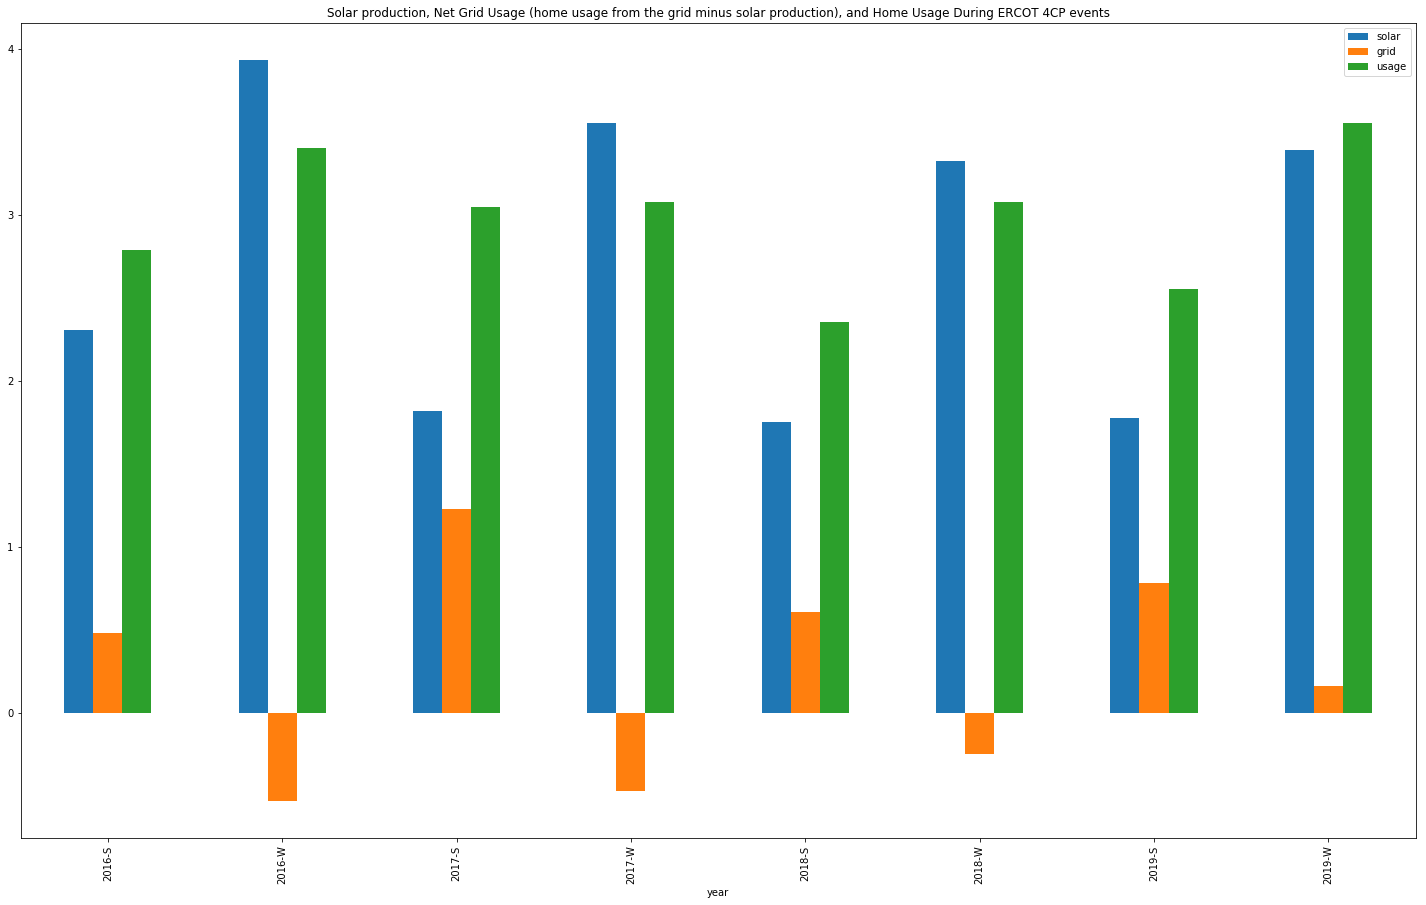

In [114]:
from matplotlib.pyplot import figure
plot = year_west_vs_south.plot(kind='bar',figsize=(25,15), title="Solar production, Net Grid Usage (home usage from the grid minus solar production), and Home Usage During ERCOT 4CP events")
labels = plot.set_xticklabels(['2016-S', '2016-W', '2017-S', '2017-W', '2018-S', '2018-W', '2019-S', '2019-W'])
